# Исследование сервиса аренды самокатов GoFast

Проанализируйте данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
- без подписки
    - абонентская плата отсутствует;
    - стоимость одной минуты поездки — 8 рублей;
    - стоимость старта (начала поездки) — 50 рублей;
- с подпиской Ultra
    - абонентская плата — 199 рублей в месяц;
    - стоимость одной минуты поездки — 6 рублей;
    - стоимость старта — бесплатно.
    
Цель исследования:
1. Предоставить рекомендации продакт-менеджерам для увеличения кол-ва пользователей.
2. Изучить поведение пользователей в приложении.
3. Установить, как наличие подписки влияет на ежемесячную выручку с пользователя.
4. Определить зависимость износа самокатов от их использования юзерами с подпиской.

    Ход исследования:
    - Обзор данных
    - Предобработка данных
    - Проведения анализа пользователей (возраст, география)
    - Проведение анализа активности пользователей (расстояние, время)
    - Объединение данных в одну таблицу
    - Проверка гипотез
    - Общий вывод

In [1]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import scipy.stats as st

### Загрузка данных

Считаем CSV-файлы с данными с помощью библиотеки Pandas и сохраним их в датафреймы

In [2]:
# считываем файл с пользователями
try:
    users = pd.read_csv('/datasets/users_go.csv')
except:
    users = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')

users.to_csv('users_go.csv')

# считываем файл с поездками
try:
    rides = pd.read_csv('/datasets/rides_go.csv')
except:
    rides = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')

rides.to_csv('rides_go.csv')

# считываем файл с подписками
try:
    subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')
except:
    subscriptions = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')

subscriptions.to_csv('subscriptions_go.csv')

Выведем первые 5 строк и общую информацию датафрейма `users`

In [3]:
# первые 5 строк таблицы users
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
# общая информация таблицы users
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


Выведем первые 5 строк и общую информацию датафрейма `rides`

In [5]:
# первые 5 строк таблицы rides
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [6]:
# общая информация таблицы rides
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


Заметим, что столбец `date` имеет тип данных object. Изменим его дальше на этапе предобработки.
Выведем первые 5 строк и общую информацию датафрейма `subscritions`

In [7]:
# строки таблицы subscriptions
subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [8]:
# общая информация таблицы subscriptions
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


# Описание данных

В основных данных есть информация о пользователях, их поездках и подписках.
- Пользователи — users_go.csv
    - user_id	уникальный идентификатор пользователя
    - name	имя пользователя
    - age	возраст
    - city	город
    - subscription_type	тип подписки (free, ultra)
- Поездки — rides_go.csv
    - user_id	уникальный идентификатор пользователя
    - distance	расстояние, которое пользователь проехал в текущей сессии (в метрах)
    - duration	продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
    - date	дата совершения поездки
- Подписки — subscriptions_go.csv
    - subscription_type	тип подписки
    - minute_price	стоимость одной минуты поездки по данной подписке
    - start_ride_price	стоимость начала поездки
    - subscription_fee	стоимость ежемесячного платежа


**Вывод:** Мы выгрузили три таблицы с данными.
- users - пользователи
- rides - поездки
- subscriptions - подписки

Изучили структуру данных и наметили шаги для предобработки данных (замена типа данных столбца `date`).
Пропущенные данные отсутствуют.

### Предобработка данных

#### Изменение типов данных

В результате исследования данных, обнаружили, что в таблице `rides` столбец `date` имеет тип object. Приведем его к типу date для выполнения дальнейших преобразований.

In [9]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')

У остальных столбцов типы данных соответствуют содержимому. Проверим наше преобразование.

In [10]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


Столбец `date` имеет тип данных date.

#### Добавление нового столбца

Для дальнейшего анализа нам нужен столбец с номером месяца в таблице `rides`. Назовем этот столбец `month`.

In [11]:
# используем атрибут month
rides['month'] = rides['date'].dt.month

Проверим новый столбец.

In [12]:
rides.head(10)

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8
5,1,2770.890808,16.650138,2021-10-09,10
6,1,3039.020292,14.927879,2021-10-19,10
7,1,2842.118050,23.117468,2021-11-06,11
8,1,3412.690668,15.238072,2021-11-14,11
9,1,748.690645,15.041884,2021-11-22,11


Столбец с месяцем добавлен.

#### Обработка дубликатов

Проверим наличие явных дубликатов. Начнем с таблицы `users`.

In [13]:
users.duplicated().sum()

31

Данные в таблице `users` действительно могут дублироваться, т.к. можно найти людей в одном городе с одинаковыми именами, возрастом и типом подписки. Но наличие дубликатов в столбце `user_id` говорит о том, что повторы действительно есть. Удалим эти строки и сделаем проверку.

In [14]:
users = users.drop_duplicates()
users.duplicated().sum()

0

Дубликаты в таблице `users` удалены. Перейдем к столбцу `rides`.

In [15]:
rides.duplicated().sum()

0

В таблице `rides` явные дубликаты отсутствуют.

В таблице `subscriptions` содержится две строки и нет смысла проверять её на наличие дубликатов.

Проверим наличие неявных дубликтов названии городов. В остальных столбцах всех таблиц проводить проверку на неявные дубликаты нет смысла.

In [16]:
# уникальные города
users['city'].sort_values().unique()

array(['Екатеринбург', 'Краснодар', 'Москва', 'Омск', 'Пятигорск',
       'Ростов-на-Дону', 'Сочи', 'Тюмень'], dtype=object)

Неявных дубликатов нет.

#### Обработка аномалий

Выведем информацию обо всех полях в таблице `rides`

In [17]:
rides.describe()

,user_id,distance,duration,month
count,18068.000000,18068.000000,18068.000000,18068.000000
mean,842.869936,3070.659976,17.805011,6.486772
std,434.734317,1116.831209,6.091051,3.437410
min,1.000000,0.855683,0.500000,1.000000
25%,487.000000,2543.226360,13.597563,4.000000
50%,889.000000,3133.609994,17.678395,6.000000
75%,1213.250000,3776.222735,21.724800,9.000000
max,1534.000000,7211.007745,40.823963,12.000000


Посторим диаграммы размаха для столбцов `distance` и `duration`

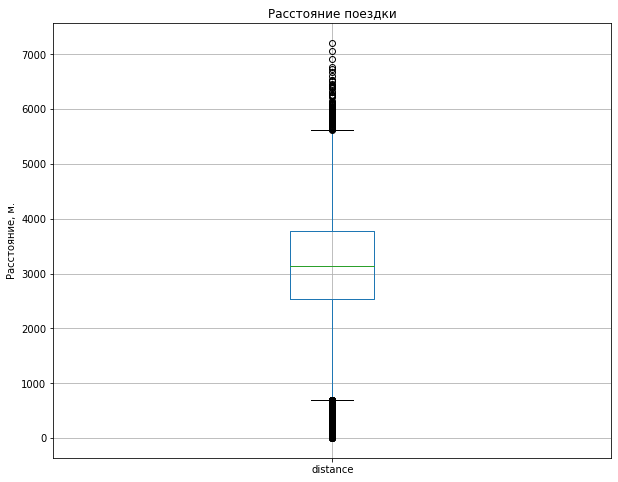

In [18]:
rides.boxplot('distance', figsize=(10,8))
plt.title('Расстояние поездки')
plt.ylabel('Расстояние, м.')
plt.show()

Видим множество выбросов как сверху, так и снизу. Но такие значения мы можем объяснить поведением пользователя. Убирать выбросы не будем. Проверим столбец `duration`.

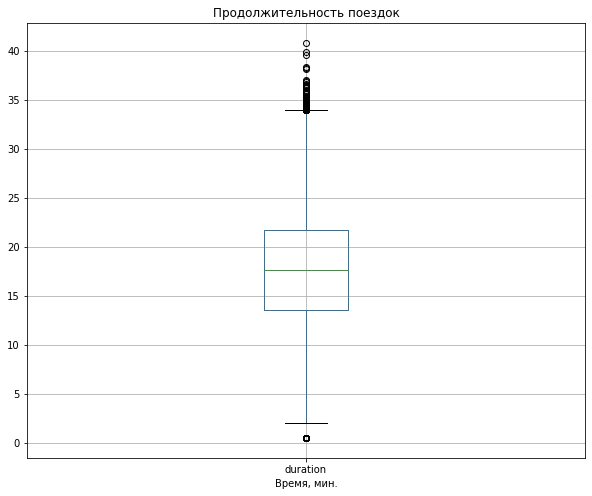

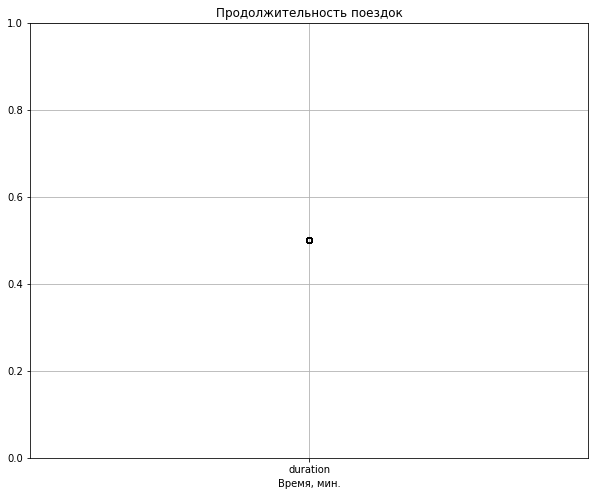

In [19]:
rides.boxplot('duration', figsize=(10,8))
plt.title('Продолжительность поездок')
plt.xlabel('Время, мин.')
plt.show()

rides.boxplot('duration', figsize=(10,8))
plt.title('Продолжительность поездок')
plt.xlabel('Время, мин.')
plt.ylim(0, 1)
plt.show()

Видим выбросы на единственной отметке 0,5 мин. Проверим какие там данные.

In [20]:
rides[rides['duration'] < 1]

,user_id,distance,duration,date,month
6531,701,4196.445201,0.5,2021-08-31,8
6570,704,4830.824371,0.5,2021-10-14,10
6680,712,4684.004397,0.5,2021-03-04,3
6695,713,5215.642710,0.5,2021-02-25,2
6768,718,5197.436649,0.5,2021-02-11,2
...,...,...,...,...,...
17004,1460,5531.335845,0.5,2021-01-19,1
17242,1477,6724.932981,0.5,2021-01-12,1
17314,1483,4445.481070,0.5,2021-03-06,3
17505,1496,5722.551787,0.5,2021-02-14,2


Значения времени действительно слишком маленькие по сравнению с пройденным расстоянием. Возможна ошибка в расчете поездки. Проверим данные от 1 до 3 минут.

In [21]:
rides[(rides['duration'] < 3) & (rides['duration'] > 1)]

,user_id,distance,duration,date,month
6691,712,23.963062,2.053251,2021-11-22,11
6801,720,102.323624,2.292353,2021-09-20,9
7453,768,273.136262,2.744917,2021-02-20,2
8676,863,466.343107,2.999307,2021-04-11,4
8906,880,11.283615,2.035632,2021-03-28,3
9320,910,126.040770,2.472653,2021-02-21,2
10291,977,90.850696,2.320650,2021-08-15,8
10865,1019,216.259429,2.480577,2021-07-26,7
11336,1053,391.007269,2.902324,2021-09-10,9
12016,1103,147.453884,2.315973,2021-02-26,2


Здесь мы видим более реалистичные значения, значит ошибка в расчетах на предыдущем этапе есть. Скорее всего неправильно рассчитывается, как раз таки время, а не расстояние. Заменить это время логически обоснованным мы не можем, значит удалим эти строки.

In [22]:
rides = rides[rides['duration'] > 0.5]
rides['duration'].describe()

count    17973.000000
mean        17.896480
std          5.975424
min          2.035632
25%         13.670439
50%         17.714122
75%         21.747016
max         40.823963
Name: duration, dtype: float64

Удалили 95 строк что составляло 5.26% от исходных данных. Считаем это допустимым.

Проверим диапазон дат в столбце `date`.

In [23]:
print('Минимальная дата: ', rides['date'].min())
print('Максимальная дата: ', rides['date'].max())

Минимальная дата:  2021-01-01 00:00:00
Максимальная дата:  2021-12-30 00:00:00


Имеем данные почти за весь 2021 год.

**Вывод:** В результате предобработки данных мы:
- изменили тип данных столбца `date` на date
- удалили явные дубликаты в таблице `users`
- добавили в таблицу `rides` столбец с месяцами(`month`)
- удалили аномальные значения в поле `duration` таблицы `rides`

### Исследовательский анализ данных

#### Частота встречаемости городов.

In [24]:
# кол-во уникальных значений
users['city'].value_counts()

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

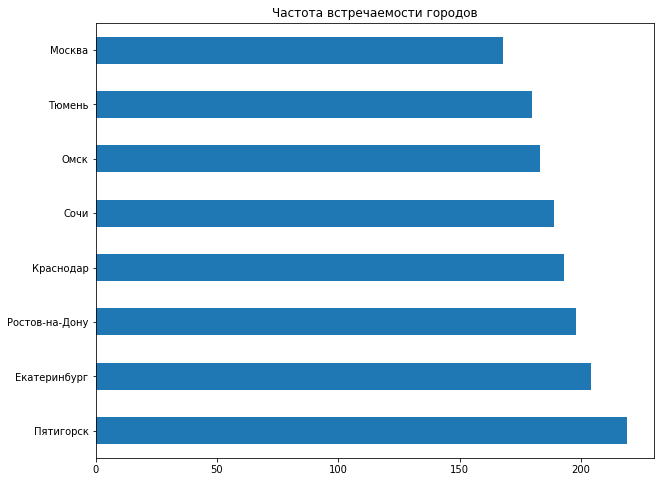

In [25]:
# гистограмма
users['city'].value_counts().plot(kind='barh', figsize=(10,8))
plt.title('Частота встречаемости городов')
plt.show()

Распределение близко к равномерному. Из них всех меньше пользователей в Москве - 168, а больше всех в Пятигорске - 219.

#### Cоотношение пользователей с подпиской и без подписки

In [26]:
# кол-во уникальных знаений
users['subscription_type'].value_counts()

free     835
ultra    699
Name: subscription_type, dtype: int64

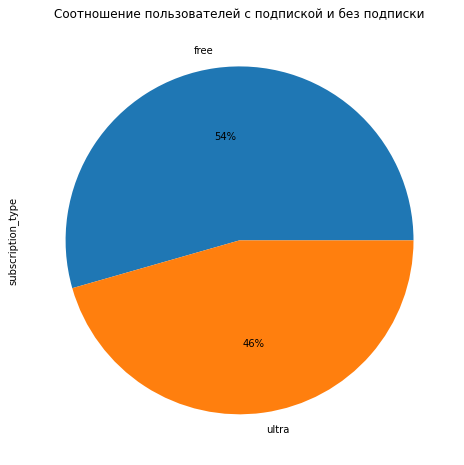

In [27]:
# круговой график
users['subscription_type'].value_counts().plot(kind='pie',figsize=(10,8), autopct='%1.0f%%')
plt.title('Cоотношение пользователей с подпиской и без подписки')
plt.show()

Количество пользователей с подпиской (46%) не сильно меньше, чем с подпиской (54%).

#### Возраст пользователей

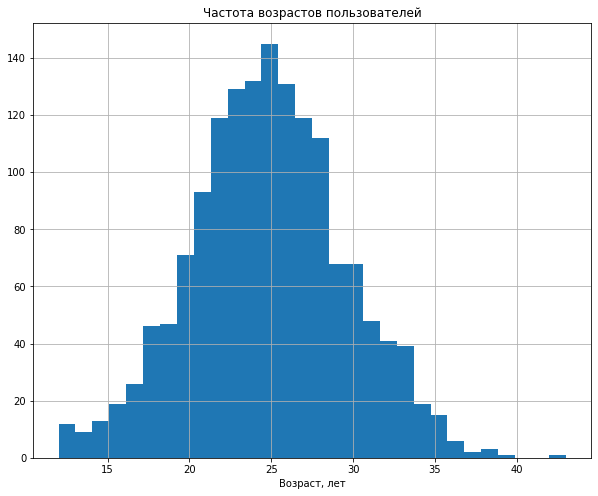

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

In [28]:
# гистограмма
users['age'].hist(figsize=(10,8), bins=30)
plt.title('Частота возрастов пользователей')
plt.xlabel('Возраст, лет')
plt.show()

# описание данных
users['age'].describe()

Распределение возрастов близко к нормальному. Значения собираются вокруг центра, которое является средним (24.9). Медиана же равна 25. Большой части ползователей сервиса от 18 до 33 лет.

#### Расстояние, которое пользователь преодолел за одну поездку

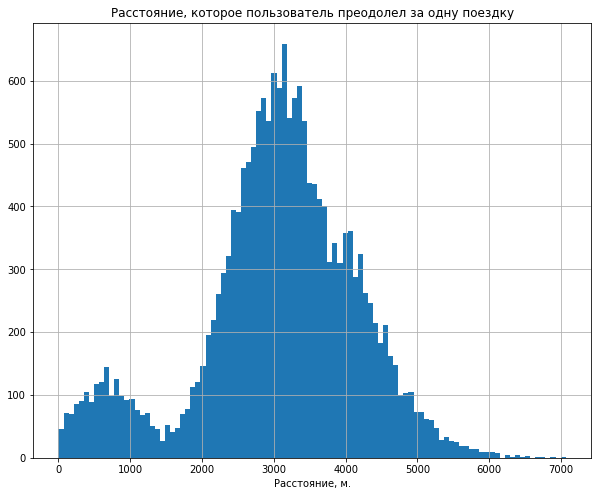

count    17973.000000
mean      3059.863833
std       1108.814612
min          0.855683
25%       2538.839628
50%       3129.029255
75%       3762.636244
max       7066.003772
Name: distance, dtype: float64

In [29]:
# гистограмма
rides['distance'].hist(figsize=(10,8), bins=100)
plt.title('Расстояние, которое пользователь преодолел за одну поездку')
plt.xlabel('Расстояние, м.')
plt.show()

# описание данных
rides['distance'].describe()

В основном самокаты берут для преодоления расстоняния от 2 до 5 км. Больше 6 км. на самокате практически не ездят. На графике можно заметить, люди также периодически берут самокат для преодоления расстояния до 1.5 км., это могут быть проездки в ближайший магазин, в гости или дургие места находящихся в пределах одной улицы.

#### Продолжительность поездок

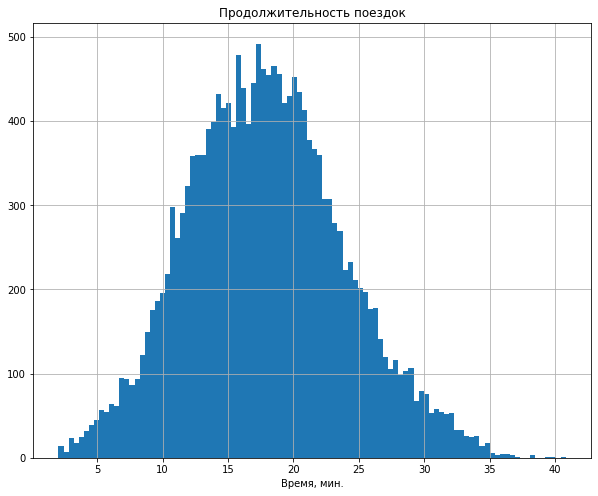

count    17973.000000
mean        17.896480
std          5.975424
min          2.035632
25%         13.670439
50%         17.714122
75%         21.747016
max         40.823963
Name: duration, dtype: float64

In [30]:
# гистограмма
rides['duration'].hist(figsize=(10,8), bins=100)
plt.title('Продолжительность поездок')
plt.xlabel('Время, мин.')
plt.show()

# описание данных
rides['duration'].describe()

Распределение близко к нормальному. Данные сосредоточенны в промежутке от 5 до 30 мин.

**Вывод:** В результате исследования данных таблиц выяснили:

- В имеющейся выборке количество пользователей в городах распределено плюс/минус равномерно, и это не зависит от численности города. Например в Москве меньше всего пользователей, хотя население в разы отличается от остальных.
- Пользователей с подпиской меньше (46% против 54%), хотя разница невелика.
- Основная аудитория сервиса имеет возраст от 18 до 33 лет.
- Самокаты берут в основном для преодоления расстояния до 1.5 км. (магазин, гости), и от 2 до 5 км (работа, прогулки)
- В осном время поездки от 5 до 30 мин.

### Объединение данных

#### Объединение данных о пользователях, поездках и подписках

In [31]:
# параметры оставляем по умолчанию. Объединение будет внутренним, 
# а таблицы будут объеденены по совпадающим столбцам user_id и subsription_type.
data = rides.merge(users).merge(subscriptions)

Проверим новую таблицу.

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17973 entries, 0 to 17972
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            17973 non-null  int64         
 1   distance           17973 non-null  float64       
 2   duration           17973 non-null  float64       
 3   date               17973 non-null  datetime64[ns]
 4   month              17973 non-null  int64         
 5   name               17973 non-null  object        
 6   age                17973 non-null  int64         
 7   city               17973 non-null  object        
 8   subscription_type  17973 non-null  object        
 9   minute_price       17973 non-null  int64         
 10  start_ride_price   17973 non-null  int64         
 11  subscription_fee   17973 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


Объединили таблицу в одну. Количество строк в `data` совпадает с кол-вом строк в таблице `rides`, значит объединили таблицы правильно.

#### Создание новых датафреймов

In [33]:
# данные о пользователях без подписки
data_no_sub = data[data['subscription_type'] == 'free']
data_no_sub.head(10)

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
6500,700,2515.690719,14.944286,2021-01-02,1,Айдар,22,Омск,free,8,50,0
6501,700,846.932642,16.234663,2021-02-01,2,Айдар,22,Омск,free,8,50,0
6502,700,4004.434142,20.016628,2021-02-04,2,Айдар,22,Омск,free,8,50,0
6503,700,1205.911290,9.782872,2021-02-10,2,Айдар,22,Омск,free,8,50,0
6504,700,3047.379435,17.427673,2021-02-14,2,Айдар,22,Омск,free,8,50,0
6505,700,4342.002254,22.368009,2021-02-23,2,Айдар,22,Омск,free,8,50,0
6506,700,3798.334905,18.243756,2021-03-03,3,Айдар,22,Омск,free,8,50,0
6507,700,2984.551206,15.424899,2021-04-09,4,Айдар,22,Омск,free,8,50,0
6508,700,3360.107141,16.765497,2021-06-12,6,Айдар,22,Омск,free,8,50,0
6509,700,2567.543847,11.312160,2021-06-23,6,Айдар,22,Омск,free,8,50,0


In [34]:
# данные о пользователях с подпиской
data_with_sub = data[data['subscription_type'] == 'ultra']
data_with_sub.head(10)

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199
5,1,2770.890808,16.650138,2021-10-09,10,Кира,22,Тюмень,ultra,6,0,199
6,1,3039.020292,14.927879,2021-10-19,10,Кира,22,Тюмень,ultra,6,0,199
7,1,2842.118050,23.117468,2021-11-06,11,Кира,22,Тюмень,ultra,6,0,199
8,1,3412.690668,15.238072,2021-11-14,11,Кира,22,Тюмень,ultra,6,0,199
9,1,748.690645,15.041884,2021-11-22,11,Кира,22,Тюмень,ultra,6,0,199


#### Исследование расстояния и времени у пользователей с подпиской и без подписки

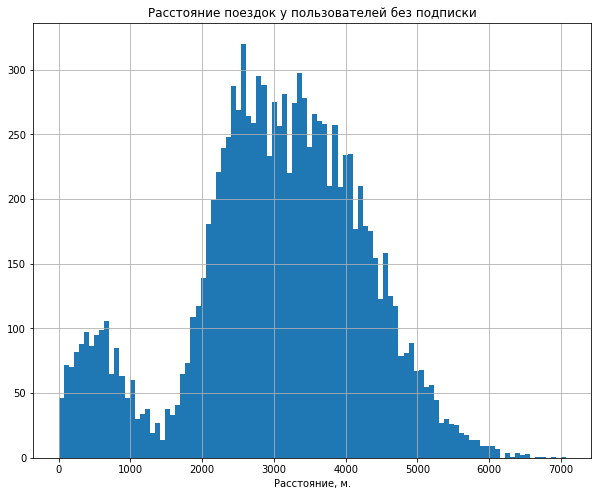

count    11473.000000
mean      3028.374239
std       1235.541051
min          0.855683
25%       2360.878149
50%       3102.083025
75%       3883.979311
max       7066.003772
Name: distance, dtype: float64

In [35]:
# расстояние поездок у пользователей без подписки
data_no_sub['distance'].hist(figsize=(10,8), bins=100)
plt.title('Расстояние поездок у пользователей без подписки')
plt.xlabel('Расстояние, м.')
plt.show()

# описание данных
data_no_sub['distance'].describe()

График по форме идентичен графику с общими данными, но смещен чуть влево (среднее время поездки меньше).

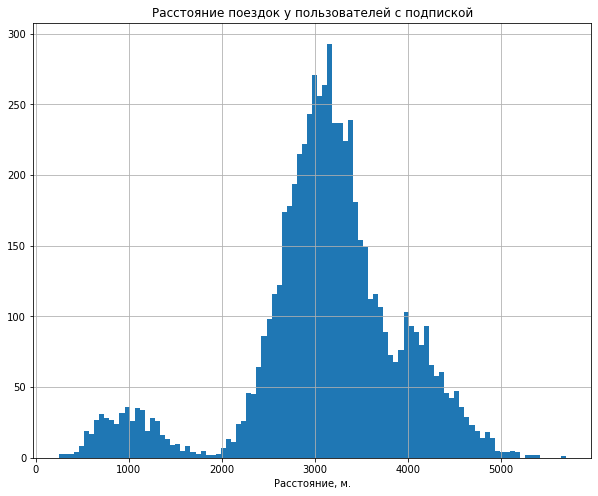

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

In [36]:
# расстояние поездок у пользователей с подпиской
data_with_sub['distance'].hist(figsize=(10,8), bins=100)
plt.title('Расстояние поездок у пользователей с подпиской')
plt.xlabel('Расстояние, м.')
plt.show()

# описание данных
data_with_sub['distance'].describe()

У пользователей с подпиской график смещен вправо (среднее время поездки больше), и менее вытянут(среднеквадратическое отклонение меньше). Пользователи без подписки совершают больше коротких поездок (до 1 км.).

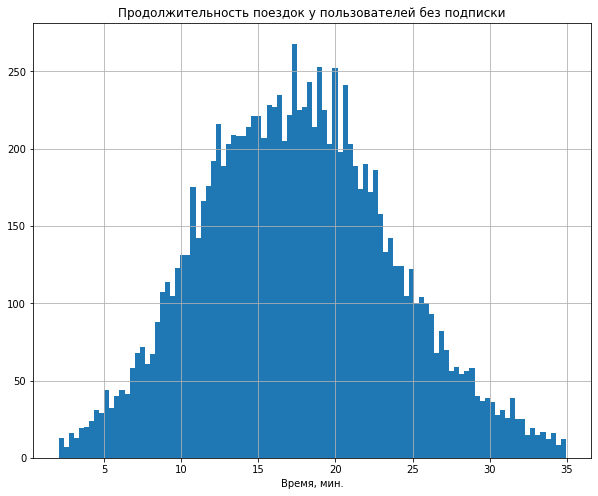

count    11473.000000
mean        17.530771
std          6.162609
min          2.035632
25%         13.085688
50%         17.383807
75%         21.638038
max         34.948498
Name: duration, dtype: float64

In [37]:
# продолжительность поездок у пользователей без подписки
data_no_sub['duration'].hist(figsize=(10,8), bins=100)
plt.title('Продолжительность поездок у пользователей без подписки')
plt.xlabel('Время, мин.')
plt.show()

# описание данных
data_no_sub['duration'].describe()

График по внешнему виду и параметрам идентичен графику со всеми данными. Cредняя продолжительность поездки меньше.

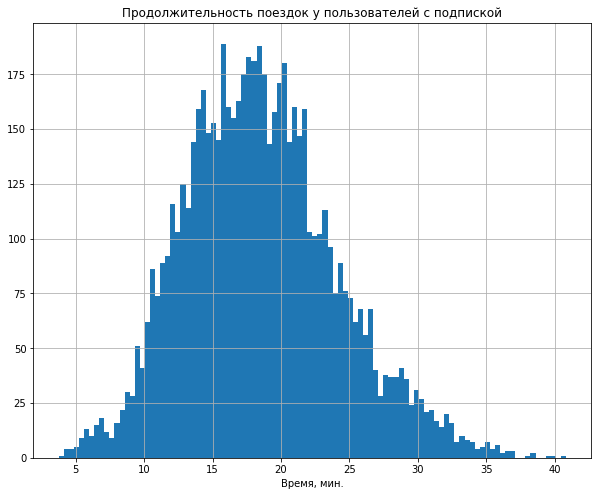

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

In [38]:
# продолжительность поездок у пользователей с подпиской
data_with_sub['duration'].hist(figsize=(10,8), bins=100)
plt.title('Продолжительность поездок у пользователей с подпиской')
plt.xlabel('Время, мин.')
plt.show()

# описание данных
data_with_sub['duration'].describe()

График по внешнему виду и параметрам идентичен графику со всеми данными. Cредняя продолжительность поездки больше. Так же заметно что график меньше вытянут.

**Вывод:** На данном этапе мы объединили три таблицы `users`, `rides` и `subscriptions` в одну - `data`, с помощью метода `merge()`. Из нее создали два датафрейма `data_with_sub` (пользователи с подпиской) и `data_no_sub` (пользователи без подписки). 

В этих датафреймах мы исследовали продолжительность поездок и расстоние, в результате чего пришли к выводу, что распределение внутри каждого набора остается близким к нормальному. У пользователей с подпиской средние изучаемых параметров ненамного смещены в большую сторону относительно пользователей без подписки. Это говорит о том, что пользователи с подпиской в целом тратят чуть больше времени, и ездят на чуть большее расстояние чем пользователи без подписки. Вероятно это связано с условиями подписки, и с ней ездить на большие расстояния более выгодно. 

Стандартное отклонение у изучаемых параметров у пользователей с подпиской меньше чем без подписки, что говорит о том что данные больше сосредоточены вокруг среднего значения. Это также можно увидеть на графиках.

### Подсчёт выручки

Создадим датафрейм с агрегированными данными о поездках на основе датафрейма `data`: найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц. Также добавим данные о подписке.

In [39]:
# используем метод groupby()
data_revenue = data.groupby(['month', 'user_id', 'subscription_fee', 'start_ride_price',
                             'minute_price']).agg({'date':'count', 'distance':'sum', 'duration':'sum'}).reset_index()
# переименуем столбец date в count_rides
data_revenue = data_revenue.rename(columns={'date':'count_rides'})
data_revenue

,month,user_id,subscription_fee,start_ride_price,minute_price,count_rides,distance,duration
0,1,1,199,0,6,2,7027.511294,41.416640
1,1,3,199,0,6,1,3061.777147,12.654443
2,1,5,199,0,6,1,3914.646990,12.395153
3,1,7,199,0,6,2,6478.080979,27.653450
4,1,12,199,0,6,1,3577.151148,32.462907
...,...,...,...,...,...,...,...,...
11295,12,1525,0,50,8,1,4597.854350,33.220866
11296,12,1526,0,50,8,1,3644.121544,22.665456
11297,12,1528,0,50,8,1,3998.569324,10.272902
11298,12,1532,0,50,8,2,6111.889853,40.128222


Проверим что один ползователь каждый месяц имеет только один вид подписки.

In [40]:
print(data_revenue.shape)
print(data.groupby(['month', 'user_id']).agg({'user_id':'count', 'distance':'sum', 'duration':'sum'}).shape)

(11300, 8)
(11300, 3)


Кол-во строк одинаково, значит все верно.

Для дальнейших расчетов, продолжительность поездки в каждой строке датафрейма `data_revenue` округлим до следующего целого числа.

In [41]:
# используем метод np.ceil() и преобразовываем в целое число
data_revenue['duration'] = np.ceil(data_revenue['duration']).astype(int)
data_revenue

,month,user_id,subscription_fee,start_ride_price,minute_price,count_rides,distance,duration
0,1,1,199,0,6,2,7027.511294,42
1,1,3,199,0,6,1,3061.777147,13
2,1,5,199,0,6,1,3914.646990,13
3,1,7,199,0,6,2,6478.080979,28
4,1,12,199,0,6,1,3577.151148,33
...,...,...,...,...,...,...,...,...
11295,12,1525,0,50,8,1,4597.854350,34
11296,12,1526,0,50,8,1,3644.121544,23
11297,12,1528,0,50,8,1,3998.569324,11
11298,12,1532,0,50,8,2,6111.889853,41


Добавим столбец с выручкой за поездку.

In [42]:
#  цена подписки + стоимость старта поездки * кол-во поездок + цена за минуту * кол-во минут
data_revenue['revenue'] =  data_revenue['subscription_fee'] + data_revenue['start_ride_price'] * data_revenue['count_rides'] + \
data_revenue['minute_price'] * data_revenue['duration']

data_revenue

,month,user_id,subscription_fee,start_ride_price,minute_price,count_rides,distance,duration,revenue
0,1,1,199,0,6,2,7027.511294,42,451
1,1,3,199,0,6,1,3061.777147,13,277
2,1,5,199,0,6,1,3914.646990,13,277
3,1,7,199,0,6,2,6478.080979,28,367
4,1,12,199,0,6,1,3577.151148,33,397
...,...,...,...,...,...,...,...,...,...
11295,12,1525,0,50,8,1,4597.854350,34,322
11296,12,1526,0,50,8,1,3644.121544,23,234
11297,12,1528,0,50,8,1,3998.569324,11,138
11298,12,1532,0,50,8,2,6111.889853,41,428


**Вывод:** Мы создали новый датафрейм с данными о поездках пользователей в разбивке по месяцам. Добавили туда выручку от каждого пользователя в месяц.

### Проверка гипотез

#### Тратят ли пользователи с подпиской больше времени на поездки

- Нулевая гипотеза: средние значения продолжительности сессии у пользователей с подпиской и без подписки равны
- Альтернативная гипотеза: среднее значение продолжительности сессии у пользователей с подпиской больше чем у пользователей без подписки

In [43]:
# задаём уровень значимости
alpha = 0.05

# продолжительной сессий у пользователей с подпиской
first_group_duration = data_with_sub['duration'] 

# продолжительной сессий у пользователей без подписки
second_group_duration = data_no_sub['duration'] 

# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу "больше"
results = st.ttest_ind(first_group_duration, second_group_duration, alternative='greater')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 4.704468074453899e-28
Отвергаем нулевую гипотезу


Полученное значение p-value значительно меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу. **Есть основания говорить, что пользователи с подпиской тратят на поездки больше времени.**

#### Расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров

- Нулевая гипотеза: продолжительности сессии у пользователей с подпиской равны 3130 метров.
- Альтернативная гипотеза: продолжительности сессии у пользователей с подпиской меньше 3130 метров.

In [44]:
# задаём уровень значимости
alpha = 0.05

# оптимальное расстояние одной поездки
interested_value = 3130

# продолжительной сессий у пользователей с подпиской
durations = data_with_sub['distance'] 

# проводим ttest для выборки и оптимального значения, в качестве альтернативной используем одностороннюю гипотезу "меньше"
results = st.ttest_1samp(durations, interested_value, alternative='less')
results1 = st.ttest_1samp(durations, interested_value, alternative='greater')


print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 0.08046311521502146
Нет оснований отвергнуть нулевую гипотезу


У нас нет достаточных доказательств для того чтобы отвергнуть гипотезу. **Пользователи с подпиской проезжают не меньше 3130 метров. Самокаты изнашиваются быстрее.**

#### Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

- Нулевая гипотеза: Помесячная выручка от пользователей с подпиской по месяцам равна выручке от пользователей без подписки.
- Альтернативная гипотеза: Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

In [45]:
# задаём уровень значимости
alpha = 0.05

# выручка у пользователей с подпиской
first_group_duration = data_revenue.loc[data_revenue['subscription_fee'] != 0, 'revenue']

# выручка у пользователей без подписки
second_group_duration = data_revenue.loc[data_revenue['subscription_fee'] == 0, 'revenue']

# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу "больше"
results = st.ttest_ind(first_group_duration, second_group_duration, alternative='greater')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 3.914474385320123e-34
Отвергаем нулевую гипотезу


Полученное значение p-value значительно меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу. **Есть основания говорить, что пользователи с подпиской приносят больше выручки, чем пользователи без подписки.**

#### Выбор теста

Исходные данные: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него.

Для проверки этой гипотезы будем использовать t-тест для зависимых парных выборок `scipy.stats.ttest_rel()`.

**Вывод:** Пользователи с подпиской тратят на поездки больше времени и приносят большую выручку чем пользователи без подписки. Но они проезжают расстояние достаточное большее чтобы ускорить износ самокатов.

### Общий вывод

В данном проекте мы изучили данные сервиса аренды самокатов GoFast. Мы изучили три таблицы с информацией о пользователях, поездках и подписках.

В процессе предобработки данных мы сделали следующее:
- изменили тип данных столбца `date` на date
- удалили явные дубликаты в таблице `users`
- добавили в таблицу `rides` столбец с месяцами(`month`)
- удалили выбросы в столбце `duration`. Значения с длительностью поездки равной 0.5 оказались аномальными.


В результате исследования данных таблиц выяснили:

- Количество пользователей в городах распределено плюс/минус равномерно, и это не зависит от численности города. 
- Пользователей с подпиской меньше чем с подпиской (46% против 54%).
- Основная аудитория сервиса имеет возраст от 18 до 33 лет.
- В основном люди ездят на расстояние от 2 до 5 км. Пользователи без подписки совершают больше коротких поездок (до 1 км.).
- В основном время поездки от 5 до 30 мин.

Позже мы объединили все данные в одну таблицу и построили сводную по месяцам и пользователям. В этой сводной рассчитали выручку которую приносит каждый пользователь за месяц.

В итоге мы проверили для продакт-менеджеров несколько гипотез чтобы помочь им определить акционные предложения для пользователей с подпиской. В результате мы выяснили следующее:
- Пользователи с подпиской тратят на поездки больше времени чем пользователи без подписки.
- Пользователи с подпиской приносят большую выручку чем пользователи без подписки. 
- Пользователи с подпиской проезжают расстояние достаточное большее чтобы ускорить износ самокатов.

Рекомендации для продакт менеджеров:
- Необходимо стимулировать пользователей приобретать платную подписку посредством проведения акций (бесплатный пробный период или со скидкой).
- Имеем 46% пользователей с подпиской, что составляет почти половину. Требуется разработка кампаний по удержанию такой большой группы клиентов.
- Зная стремительный характер износа самокатов, особенно при использовании платными подписчиками, проверить и доработать имеющиеся средства и инструменты для оперативного ремонта. Это также не позволит увеличить количество несчастных случаев.
- Найти и справить ошибку приводящую к расчету времени поездки в 0.5 мин. Проверить, как отображается эта информация у пользователей.
- Если выборка пользователей проводилась из всех покрытых населенных пунктов, то нужно расширять географию присутствия сервиса, не задействованы многие города-миллионики. Также нужно уделить внимание городам поменьше, с минимальным присутствием конкурентов.